/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg


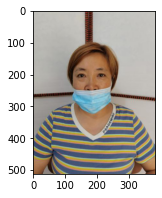

In [27]:
Imagepath = df.iloc[0].ImageFullPath
print(Imagepath)
img = np.array(Image.open(Imagepath))
plt.figure(figsize=(6,3))
plt.imshow(img)

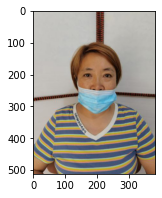

In [28]:
from albumentations import *

horizonflip_transcompose = Compose([HorizontalFlip(p=1)])
plt.figure(figsize=(6,3))
plt.imshow(horizonflip_transcompose(image=img)['image'])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class Conv3x3BNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1):
        super(Conv3x3BNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=False)
    
class Conv1x1BNReLU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1BNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=False)

class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        
        self.Conv1_1 = Conv3x3BNReLU(in_channels=3, out_channels=32, stride=1, padding=1)
        self.Conv1_2 = Conv3x3BNReLU(in_channels=32, out_channels=64, stride=2)
        self.Block1 = nn.Sequential(
            Conv1x1BNReLU(64, 32),
            Conv3x3BNReLU(32, 64)
        )
        
        self.Conv2 = Conv3x3BNReLU(in_channels=64, out_channels=128, stride=2)
        self.Block2 = nn.Sequential(
            Conv1x1BNReLU(128, 64),
            Conv3x3BNReLU(64, 128)
        )
        
        self.Conv3 = Conv3x3BNReLU(in_channels=128, out_channels=256, stride=2)
        self.Block3 = nn.Sequential(
            Conv1x1BNReLU(256, 128),
            Conv3x3BNReLU(128, 256)
        )
        
        self.Conv4 = Conv3x3BNReLU(in_channels=256, out_channels=512, stride=2)
        self.Block4 = nn.Sequential(
            Conv1x1BNReLU(512, 256),
            Conv3x3BNReLU(256, 512)
        )
        
        self.Conv5 = Conv3x3BNReLU(in_channels=512, out_channels=1024, stride=2)
        self.Block5 = nn.Sequential(
            Conv1x1BNReLU(1024, 512),
            Conv3x3BNReLU(512, 1024)
        )        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.Conv1_1(x)
        x = self.Conv1_2(x)
        x_temp = x.clone()
        x = self.Block1(x)
        x += x_temp
        
        x = self.Conv2(x)
        for i in range(2):
            x_temp = x.clone()
            x = self.Block2(x)
            x += x_temp
        
        x = self.Conv3(x)
        for i in range(8):
            x_temp = x.clone()
            x = self.Block3(x)
            x += x_temp
        
        x = self.Conv4(x)
        for i in range(8):
            x_temp = x.clone()
            x = self.Block4(x)
            x += x_temp
        
        x = self.Conv5(x)
        for i in range(4):
            x_temp = x.clone()
            x = self.Block5(x)
            x += x_temp
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [6]:
from torchsummary import summary
CustomModel = MyModel().cuda()
summary(CustomModel, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
     Conv3x3BNReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
     Conv3x3BNReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           2,080
       BatchNorm2d-8         [-1, 32, 128, 128]              64
     Conv1x1BNReLU-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          18,496
      BatchNorm2d-11         [-1, 64, 128, 128]             128
    Conv3x3BNReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
      BatchNorm2d-14          [-1, 128,